## Importing the relevant libraries

In [1]:
import torch, time
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer

## Loading the dataset

In [2]:
df = pd.read_csv("/kaggle/input/bank-marketing/bank-full.csv",sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


## Data Exploration

In [3]:
df.shape

(45211, 17)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [5]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [6]:
df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [7]:
df.duplicated().sum()

0

In [8]:
df['campaign_efficiency'] = df['duration'] / (df['campaign'] + 1)
df['campaign_efficiency'] = df['campaign_efficiency'].astype(float)

In [9]:
df['prev_contact_success_rate'] = df['previous'] / (df['pdays'] + 1)
df['prev_contact_success_rate'] = df['prev_contact_success_rate'].astype(float)

In [10]:
imputer = KNNImputer()
df['prev_contact_success_rate'] = imputer.fit_transform(df[['prev_contact_success_rate']])

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        45211 non-null  int64  
 1   job                        45211 non-null  object 
 2   marital                    45211 non-null  object 
 3   education                  45211 non-null  object 
 4   default                    45211 non-null  object 
 5   balance                    45211 non-null  int64  
 6   housing                    45211 non-null  object 
 7   loan                       45211 non-null  object 
 8   contact                    45211 non-null  object 
 9   day                        45211 non-null  int64  
 10  month                      45211 non-null  object 
 11  duration                   45211 non-null  int64  
 12  campaign                   45211 non-null  int64  
 13  pdays                      45211 non-null  int

## Separating the categorical and continous features

In [12]:
cat_cols = df.drop('y',axis=1).select_dtypes(object).columns
cont_cols = df.select_dtypes(np.number).columns
y_col = 'y'

In [13]:
for col in cat_cols:
    df[col] = df[col].astype('category')

In [14]:
cat_cols

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome'],
      dtype='object')

In [15]:
cats = np.stack([df[col].cat.codes.values for col in cat_cols],axis=1)
cats

array([[4, 1, 2, ..., 2, 8, 3],
       [9, 2, 1, ..., 2, 8, 3],
       [2, 1, 1, ..., 2, 8, 3],
       ...,
       [5, 1, 1, ..., 0, 9, 2],
       [1, 1, 1, ..., 1, 9, 3],
       [2, 1, 1, ..., 0, 9, 1]], dtype=int8)

In [16]:
conts = np.stack([df[col].values for col in cont_cols],axis=1)
conts

array([[5.80000000e+01, 2.14300000e+03, 5.00000000e+00, ...,
        0.00000000e+00, 1.30500000e+02, 3.06117004e-02],
       [4.40000000e+01, 2.90000000e+01, 5.00000000e+00, ...,
        0.00000000e+00, 7.55000000e+01, 3.06117004e-02],
       [3.30000000e+01, 2.00000000e+00, 5.00000000e+00, ...,
        0.00000000e+00, 3.80000000e+01, 3.06117004e-02],
       ...,
       [7.20000000e+01, 5.71500000e+03, 1.70000000e+01, ...,
        3.00000000e+00, 1.87833333e+02, 1.62162162e-02],
       [5.70000000e+01, 6.68000000e+02, 1.70000000e+01, ...,
        0.00000000e+00, 1.01600000e+02, 3.06117004e-02],
       [3.70000000e+01, 2.97100000e+03, 1.70000000e+01, ...,
        1.10000000e+01, 1.20333333e+02, 5.82010582e-02]])

In [17]:
cats = torch.tensor(cats,dtype=torch.int64)
cats[:5]

tensor([[ 4,  1,  2,  0,  1,  0,  2,  8,  3],
        [ 9,  2,  1,  0,  1,  0,  2,  8,  3],
        [ 2,  1,  1,  0,  1,  1,  2,  8,  3],
        [ 1,  1,  3,  0,  1,  0,  2,  8,  3],
        [11,  2,  3,  0,  0,  0,  2,  8,  3]])

In [18]:
conts = torch.tensor(conts,dtype=torch.float)
conts[:5]

tensor([[ 5.8000e+01,  2.1430e+03,  5.0000e+00,  2.6100e+02,  1.0000e+00,
         -1.0000e+00,  0.0000e+00,  1.3050e+02,  3.0612e-02],
        [ 4.4000e+01,  2.9000e+01,  5.0000e+00,  1.5100e+02,  1.0000e+00,
         -1.0000e+00,  0.0000e+00,  7.5500e+01,  3.0612e-02],
        [ 3.3000e+01,  2.0000e+00,  5.0000e+00,  7.6000e+01,  1.0000e+00,
         -1.0000e+00,  0.0000e+00,  3.8000e+01,  3.0612e-02],
        [ 4.7000e+01,  1.5060e+03,  5.0000e+00,  9.2000e+01,  1.0000e+00,
         -1.0000e+00,  0.0000e+00,  4.6000e+01,  3.0612e-02],
        [ 3.3000e+01,  1.0000e+00,  5.0000e+00,  1.9800e+02,  1.0000e+00,
         -1.0000e+00,  0.0000e+00,  9.9000e+01,  3.0612e-02]])

In [19]:
y = torch.tensor(df[y_col].astype('category').cat.codes.values,dtype=torch.long).flatten()
y

tensor([0, 0, 0,  ..., 1, 0, 0])

In [20]:
cats.shape, conts.shape, y.shape

(torch.Size([45211, 9]), torch.Size([45211, 9]), torch.Size([45211]))

In [21]:
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size,min(50,(1+size)//2)) for size in cat_szs]
emb_szs

[(12, 6), (3, 2), (4, 2), (2, 1), (2, 1), (2, 1), (3, 2), (12, 6), (4, 2)]

## Defining the model architecture

In [59]:
class TabularModel(nn.Module):
    
    def __init__(self,emb_sizes,n_cont,out_sz,layers,p=0.4):
        super().__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(ni,nf) for ni,nf in emb_sizes])
        self.embeddings_dropout = nn.Dropout(p)
        self.batch_norm_cont = nn.BatchNorm1d(n_cont)
        total_embeddings = sum([nf for ni,nf in emb_szs])
        n_inputs = total_embeddings + n_cont
        layerList = []
        
        for n_layers in layers:
            layerList.append(nn.Linear(n_inputs,n_layers))
            layerList.append(nn.ReLU(inplace=True))
            layerList.append(nn.BatchNorm1d(n_layers))
            layerList.append(nn.Dropout(p))
            n_inputs = n_layers
        
        layerList.append(nn.Linear(layers[-1],out_sz))
        self.layers = nn.Sequential(*layerList)
        
    def forward(self,x_cat,x_cont):
        embeds = []
        
        for idx, embedding in enumerate(self.embeddings):
            embeds.append(embedding(x_cat[:,idx]))
        
        embeds = torch.cat(embeds,dim=1)
        embeds = self.embeddings_dropout(embeds)
        cont_norm = self.batch_norm_cont(x_cont)
        combined_embs = torch.cat([embeds,cont_norm],dim=1)
        return self.layers(combined_embs)

In [60]:
torch.manual_seed(42)
model = TabularModel(emb_szs,conts.shape[1],2,[200,100],p=0.45)
model

TabularModel(
  (embeddings): ModuleList(
    (0): Embedding(12, 6)
    (1): Embedding(3, 2)
    (2): Embedding(4, 2)
    (3-5): 3 x Embedding(2, 1)
    (6): Embedding(3, 2)
    (7): Embedding(12, 6)
    (8): Embedding(4, 2)
  )
  (embeddings_dropout): Dropout(p=0.45, inplace=False)
  (batch_norm_cont): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=32, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.45, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.45, inplace=False)
    (8): Linear(in_features=100, out_features=2, bias=True)
  )
)

In [61]:
total_params = 0

for param in model.parameters():
    total_params += param.numel()
    
print("Total model parameters:",total_params)

Total model parameters: 27698


In [62]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),lr=0.001)

## Splitting the continuous and categorical features into train and test sets

In [63]:
batch_size = 36000
test_size = 9000

cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
cont_train = conts[:batch_size-test_size]
cont_test = conts[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [64]:
cat_train.shape, cat_test.shape

(torch.Size([27000, 9]), torch.Size([9000, 9]))

In [65]:
cont_train.shape, cont_test.shape

(torch.Size([27000, 9]), torch.Size([9000, 9]))

In [66]:
y_train.shape, y_test.shape

(torch.Size([27000]), torch.Size([9000]))

## Model Training & Evaluation

In [67]:
start_time = time.time()

epochs = 100

losses = []

for i in range(epochs):
    y_pred = model(cat_train,cont_train)
    loss = criterion(y_pred,y_train)
    losses.append(loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i % 10 == 0:
        print(f"Epoch {i} -> Loss: {loss.item()}")
    
print(f"Total time elapsed in model training: {(time.time()-start_time)/60} minutes.")

Epoch 0 -> Loss: 0.7291816473007202
Epoch 10 -> Loss: 0.612591028213501
Epoch 20 -> Loss: 0.5726220011711121
Epoch 30 -> Loss: 0.5438851118087769
Epoch 40 -> Loss: 0.5152454972267151
Epoch 50 -> Loss: 0.48896676301956177
Epoch 60 -> Loss: 0.45257824659347534
Epoch 70 -> Loss: 0.40265539288520813
Epoch 80 -> Loss: 0.355360746383667
Epoch 90 -> Loss: 0.3024543225765228
Total time elapsed in model training: 0.2479020078976949 minutes.


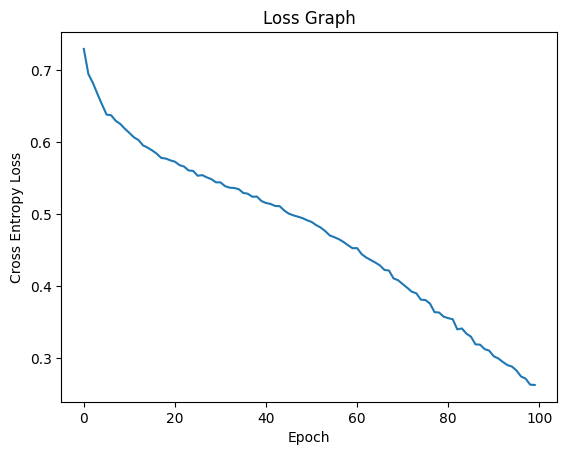

In [68]:
plt.plot(range(epochs),losses)
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.show();

In [70]:
model.eval()

with torch.no_grad():
    y_val = model(cat_test,cont_test)
    print("Loss on the test set:",criterion(y_val,y_test).item())

Loss on the test set: 0.35611292719841003


## Model Inference

In [71]:
torch.save(model,'bank_marketing_classifier.pt') # Save the trained model

In [72]:
loaded_model = torch.load("bank_marketing_classifier.pt") # Load the saved model for inference on test data
loaded_model

/tmp/ipykernel_36/947588336.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load("bank_marketing_classifier.pt") # Load the saved model for inferenc

TabularModel(
  (embeddings): ModuleList(
    (0): Embedding(12, 6)
    (1): Embedding(3, 2)
    (2): Embedding(4, 2)
    (3-5): 3 x Embedding(2, 1)
    (6): Embedding(3, 2)
    (7): Embedding(12, 6)
    (8): Embedding(4, 2)
  )
  (embeddings_dropout): Dropout(p=0.45, inplace=False)
  (batch_norm_cont): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=32, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.45, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.45, inplace=False)
    (8): Linear(in_features=100, out_features=2, bias=True)
  )
)

In [73]:
def test_data(model):
    job = input("What is the job type of the customer?")
    marital_status = input("What is the marital status of the customer?")
    education = input("What is the education level of the customer?")
    default = input("Does the customer have credit in default? (Yes/No)")
    housing = input("Does the customer have a housing loan? (Yes/No)")
    loan = input("Does the customer have a personal loan? (Yes/No)")
    contact = input("What is the customer's contact communication type?")
    month = input("In which month was the customer last contacted?")
    poutcome = input("What was the outcome of the previous marketing campaign?")
    age = int(input("What is the customer's age?"))
    balance = float(input("What is the average annual balance of the customer? (in Euros)"))
    day = int(input("On which day was the customer last contacted?"))
    duration = float(input("How long was the duration of the last customer contact?"))
    campaign = int(input("How many contacts have been made with the customer in this marketing campaign?"))
    pdays = int(input("How many days have elapsed since the customer was last contacted in the previous campaign?"))
    previous = int(input("How many contacts were performed during the previous marketing campaign?"))
    campaign_efficiency = float(input("What was the average call length per campaign?"))
    prev_contact_success_rate = float(input("What was the previous contact success rate?"))
    
    input_features_dict = {
        'job': job,
        'marital': marital_status,
        'education': education,
        'default': default,
        'housing': housing,
        'loan': loan,
        'contact': contact,
        'month': month,
        'poutcome': poutcome,
        'age': age,
        'balance': balance,
        'day': day,
        'duration': duration,
        'campaign': campaign,
        'pdays': pdays,
        'previous': previous,
        'campaign_efficiency': campaign_efficiency,
        'prev_contact_success_rate': prev_contact_success_rate
    }
    data = pd.DataFrame(input_features_dict,index=[0])

    for col in cat_cols: 
        data[col] = data[col].astype('category')
    
    x_cat = np.stack([data[col].cat.codes.values for col in cat_cols],axis=1)
    x_cat = torch.tensor(x_cat,dtype=torch.int64)
    x_cont = np.stack([data[col].values for col in cont_cols],axis=1)
    x_cont = torch.tensor(x_cont,dtype=torch.float)
    
    with torch.no_grad():
        pred = loaded_model(x_cat,x_cont).argmax().item()
        
    if pred == 1:
        print("The client has subscribed to the term deposit.")
    else:
        print("The client has not subscribed to the term deposit.")

In [76]:
test_data(loaded_model)

What is the job type of the customer? technician
What is the marital status of the customer? single
What is the education level of the customer? primary
Does the customer have credit in default? (Yes/No) yes
Does the customer have a housing loan? (Yes/No) yes
Does the customer have a personal loan? (Yes/No) no
What is the customer's contact communication type? telephone
In which month was the customer last contacted? may
What was the outcome of the previous marketing campaign? unknown
What is the customer's age? 27
What is the average annual balance of the customer? (in Euros) 13
On which day was the customer last contacted? 4
How long was the duration of the last customer contact? 178
How many contacts have been made with the customer in this marketing campaign? 2
How many days have elapsed since the customer was last contacted in the previous campaign? 56
How many contacts were performed during the previous marketing campaign? 4
What was the average call length per campaign? 59.33
Wh

The client has not subscribed to the term deposit.
